

# Spectral Clustering

::: {.hidden}

$$
\newcommand{\mA}{\mathbf{A}}
\newcommand{\mD}{\mathbf{D}}
\newcommand{\mL}{\mathbf{L}}
\newcommand{\mY}{\mathbf{Y}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\cY}{\mathcal{Y}}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\vones}{\mathbb{1}}
\newcommand{\vzero}{\mathbb{0}}
\newcommand{\braces}[1]{\left\{#1\right\}}
\newcommand{\brackets}[1]{\left[#1\right]}
\newcommand{\paren}[1]{\left(#1\right)}
\newcommand{\R}{\mathbb{R}}

\newcommand{\norm}[1]{\lVert #1 \rVert}

\newcommand{\cut}[2]{\mathrm{\mathbf{{cut}}}\paren{#1,#2}}
\newcommand{\vol}[1]{\mathrm{\mathbf{{vol}}}\paren{#1}}

\DeclareMathOperator*{\argmin}{arg\,min}
$$

:::

We continue our study of the clustering problem. We'll focus today on the problem of splitting a graph into two pieces. Suppose we have a graph $G = (N,E)$ with adjacency matrix $\mA \in \R^n$. Our aim is to determine a vector $\vz \in \braces{0,1}^n$ that splits the graph into two clusters: $C_0 = \braces{i \in N  : z_i = 0}$ and $C_1 = \braces{i \in N: z_i = 1}$. We aim for these clusters to be "good" in some sense, which usually means that there are many edges within each $C_i$ but relatively few edges between $C_0$ and $C_1$. [The problem of splitting a graph into two clusters is sometimes called the *biclustering problem*.]{.aside}

In this set of notes, we'll introduce *Laplacian spectral clustering*, which we'll usually just abbreviate to *spectral clustering*. Spectral clustering is an eigenvector-based method for determining such a vector $\vz$, or, equivalently, the  two sets $C_0$ and $C_1$.

## Defining the Spectral Clustering Objective

Many clustering algorithms proceed by optimizing or approximately optimizing a certain objective function.[^1] Spectral clustering is one such approximate optimization approach. In order to define the objective function for spectral clustering, we first need to introduce some notation.

[^1]: Modularity maximization is an example we've seen before.


::: {#def-cut-and-vol}

## Cut and Volume

The *cut* of a partition $(C_0, C_1)$ on a graph $G$, written $\cut{C_0}{C_1}$, is  the number of edges with an edge in each cluster:  
$$
\begin{aligned}
    \cut{C_0}{C_1} &\triangleq \sum_{i \in C_0, j \in C_1} a_{ij}
\end{aligned}
$$

The *volume* of a set $C\subseteq N$ is the sum of the degrees of the nodes in $C$:

$$
\begin{aligned}
    \vol{C} &\triangleq \sum_{i \in C} k_i = \sum_{i \in C} \sum_{j \in N} a_{ij}\;.
\end{aligned}
$$

:::

Let's implement the cut and volume functions in Python given an adjacency matrix $\mA$ and a partition $(C_0, C_1)$ encoded as a vector $\vz \in \braces{0,1}^n$. First, we'll load some libraries and grab a graph for clustering:

In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

def unweight(G):
    for source, target in G.edges():
        G[source][target]['weight'] = 1
    return G

G = unweight(nx.karate_club_graph())
A = nx.to_numpy_array(G)

Now we'll implement the cut and volume.

In [2]:
def cut(A, z):
    return np.sum(A[z == 0][:, z == 1])

def vol(A, z, i):
    return np.sum(A[z == i])

To get a feel for things, let's see how cut scores look for two clusterings, one of which looks "visually pretty good" and one of which is completely random.


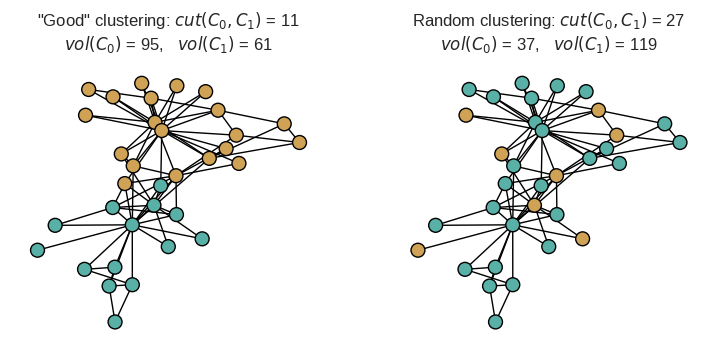

In [8]:
# get a "pretty good" set of clusters using a built-in algorithm.
partition = nx.algorithms.community.louvain.louvain_communities(G, resolution = 0.4)
z = np.array([0 if node in partition[0] else 1 for node in G.nodes()])

# random clusters
z_rand = np.random.randint(0, 2, 34)

# plot the two clusterings side-by-side
pos = nx.spring_layout(G)

fig, ax = plt.subplots(1, 2, figsize = (9, 3.75))
nx.draw(G, pos, ax = ax[0], node_color = z, cmap = plt.cm.BrBG, node_size = 100, vmin = -0.5, vmax = 1.5, edgecolors = 'black')
nx.draw(G, pos, ax = ax[1], node_color = z_rand, cmap = plt.cm.BrBG, node_size = 100, vmin = -0.5, vmax = 1.5, edgecolors = 'black')

t = ax[0].set_title(fr'"Good" clustering: $cut(C_0, C_1)$ = {cut(A, z):.0f}' + "\n" +   fr'$vol(C_0)$ = {vol(A, z, 0):.0f},   $vol(C_1)$ = {vol(A, z, 1):.0f}')
t = ax[1].set_title(fr'Random clustering: $cut(C_0, C_1)$ = {cut(A, z_rand):.0f}' + "\n" +   fr'$vol(C_0)$ = {vol(A, z_rand, 0):.0f},   $vol(C_1)$ = {vol(A, z_rand, 1):.0f}')

The visually appealing clustering has a substantially lower cut score than the random clustering.

## Engineering an Objective Function

How can we use the cut and volume to find useful clusterings? Our general idea is to seek a biclustering $(C_0, C_1)$ that that minimizes some function $f(C_0, C_1)$ defined in terms of the cut and volume:

$$
\begin{aligned}
    C_0^*, C_1^* = \argmin_{C_0, C_1} f(C_0, C_1)\;.
\end{aligned}
$$

The function $f$ should be small when $(C_0, C_1)$ is a "good" clustering and large when $(C_0, C_1)$ is a "bad" clustering. How can we combine the cut and volume in order to express this idea?

One initially appealing idea is to simply let $f$ be the cut size:

$$
\begin{aligned}
    f(C_0, C_1) = \cut{C_0}{C_1}\;.
\end{aligned}
$$

The problem with this approach is that it encourages us to put every node in the same cluster. For example, if $C_0 = N$ and $C_1 = \emptyset$, then all nodes have label $0$ and $\cut{C_0}{C_1} = 0$. This is the smallest realizable cut size, but isn't a very useful solution to the clustering problem!

A general intuition that guides many approaches to the clustering problem is:

> A good clustering produces a small cut while maintaining relatively large volumes for all clusters.

That is, we want $f(C_0, C_1)$ to be small when $\cut{C_0}{C_1}$ is small and $\vol{C_0}$ and $\vol{C_1}$ are large.

Here's one candidate $f$ that encodes this intuition. Let $\vol{G} = \sum_{i \in N} k_i = 2m$ be the total volume of the graph. Then, let

$$
\begin{aligned}
    f(C_0, C_1) = \cut{C_0}{C_1} + \frac{1}{4\vol{G}}\paren{\vol{C_0} - \vol{C_1}}^2\;.
\end{aligned}
$$

Observe that this function $f$ has two counterbalancing terms. The first term is small when the cut term is small, while the second term is small when the two clusters $C_0$ and $C_1$ have similar volumes, and vanishes in the case when the two clusters have identical volumes.
In fact, this function $f$ is a disguised form of the modularity, [which we have previously seen](06-modularity.qmd). As shown by @gleich2016mining, minimizing $f$ is equivalent to maximizing the modularity.

Since we've already seen modularity maximization, let's consider a different way of managing the tradeoff between cut and volume. Consider the objective function

$$
\begin{aligned}
    f(C_0, C_1) = \cut{C_0}{C_1}\paren{\frac{1}{\vol{C_0}} + \frac{1}{\vol{C_1}}}\;.
\end{aligned}
$$

This is the *normalized cut* or *NormCut* objective function, and its minimization is the problem that will guide our development of spectral clustering. [Our choice of the NormCut objective function will guide us towards the spectral clustering algorithm of @shi2000normalized. There are alternative objective functions which also lead to forms of Laplacian spectral clustering;  @luxburgTutorialSpectralClustering2007 offer a comprehensive discussion.]{.aside}

Let's implement the normalized cut and check that it gives a lower score to the "good" clustering than to the random clustering:

In [9]:
def norm_cut(A, z):
  return cut(A, z)*(1/vol(A, z, 0) + 1/vol(A, z, 1))

In [10]:
print(f"NormCut of good clustering: {norm_cut(A, z):.2f}")
print(f"NormCut of random clustering: {norm_cut(A, z_rand):.2f}")

NormCut of good clustering: 0.30
NormCut of random clustering: 0.96


As expected, the normcut of the good clustering is much lower than the normcut of the random clustering.

## From NormCut to Eigenvectors

Is that it? Are we done? Could we simply define a clustering algorithm that finds clusters which minimize the NormCut? Unfortunately, this appealing idea isn't practical: the problem of finding the partition that minimizes the normalized cut is NP-hard [@wagner1993between]. So, in order to work with large instances, we need to find an *approximate* solution of the NormCut minimization problem that admits an efficient solution. [Our development in the remainder of these notes closely follows that of @luxburgTutorialSpectralClustering2007, which in turn follows the original development of @shi2000normalized.]{.aside}

Our strategy is to express the NormCut objective in linear algebraic terms. To do this, define the vector $\vy \in \R^n$ with entries [Recall that the condition $i \in C_0$ is equivalent to $z_i = 0$.]{.aside}

$$
\begin{aligned}
    y_i = \begin{cases}
        &\frac{1}{\sqrt{2m}}\sqrt{\frac{\vol{C_1}}{\vol{C_0}}} & \text{if } i \in C_0\;, \\
        -&\frac{1}{\sqrt{2m}}\sqrt{\frac{\vol{C_0}}{\vol{C_1}}} & \text{if } i \in C_1\;.
    \end{cases}
\end{aligned}
$$ {#eq-y}

The vector $\vy$ is as good as $\vz$ for the purposes of clustering: the sign of $y_i$ completely determines the cluster of node $i$.

::: {.callout-important}

## Exercise

Prove the following properties of $\vy$:

1. **Normalization**: $\vy^T\mD\vy = 1$.
2. **Objective**: $\mathrm{NormCut}(C_0, C_1) = \vy^T \mL \vy$, where $\mD$ is the diagonal matrix with entries $d_{ii} = k_i$, the degree of node $i$, and $\mL = \mD - \mA$ is our good friend the combinatorial graph Laplacian.
3. **Orthogonality**: $\vy^T\mD \vones = 0$, where $\vones$ is the all-ones vector.

:::

::: {.hide .solution}

It's convenient to first check normalization. We have
$$
\begin{aligned}
    \vy^T\mD\vy &= \sum_{1 \leq i,j \leq n} d_{ij} y_i y_j \\
    &= \sum_{1 \leq i \leq n} k_{i}y_i^2 \quad \text{($\mD$ is diagonal)}\\
    &= \sum_{i \in C_0} k_{i}y_i^2 + \sum_{i \in C_1} k_{i}y_i^2 &\\
    &= \frac{1}{2m}\brackets{ \frac{\vol{C_1}}{\vol{C_0}} \sum_{i \in C_0} k_{i} +  \frac{\vol{C_0}}{\vol{C_1}} \sum_{i \in C_1} k_{i}} \\
    &= \frac{1}{2m}\brackets{ \frac{\vol{C_1}}{\vol{C_0}} \vol{C_0} +  \frac{\vol{C_0}}{\vol{C_1}} \vol{C_1}} &\quad \text{(def. of $\vol{C}$)} \\
    &= \frac{1}{2m}\brackets{\vol{C_0} + \vol{C_1}} \\
    &= \frac{1}{2m} 2m\\
    &= 1 \;.
\end{aligned}
$$

Now let's check the objective. Since $\vy^T\mL\vy = \vy^T\mD\vy - \vy^T\mA\vy$, we only need to compute $\vy^T\mA\vy$. It's helpful to keep in mind here that
$$
\begin{aligned}
    y_iy_j = \begin{cases}
        -\frac{1}{2m} & \text{if } i \in C_0, j \in C_1 \text{ or } i \in C_1, j \in C_0\;, \\
        \frac{1}{2m} \frac{\vol{C_1}}{\vol{C_0}} & \text{if } i, j \in C_0\;, \\
        \frac{1}{2m} \frac{\vol{C_0}}{\vol{C_1}} & \text{if } i, j \in C_1\;.
    \end{cases}
\end{aligned}
$$

Another pair of useful identities is

$$
\begin{aligned}
    \sum_{i \in C_0, j \in C_0}a_{ij} &= \sum_{i \in C_0, j \in N} a_{ij} - \sum_{i \in C_0, j \in C_1} a_{ij} = \vol{C_0} - \cut{C_0}{C_1} \\
    \sum_{i \in C_1, j \in C_1}a_{ij} &= \sum_{i \in C_1, j \in N} a_{ij} - \sum_{i \in C_1, j \in C_0} a_{ij} = \vol{C_1} - \cut{C_0}{C_1}\;.
\end{aligned}
$$


We'll now proceed with the computation:

$$
\begin{aligned}
\vy^T \mA \vy &= \sum_{1 \leq i, j \leq n} a_{ij} y_i y_j \\
&= \sum_{i \in C_0, j \in C_1} a_{ij} y_i y_j + \sum_{i \in C_1, j \in C_0} a_{ij} y_i y_j + \sum_{i \in C_0, j \in C_0} a_{ij} y_i y_j + \sum_{i \in C_1, j \in C_1} a_{ij} y_i y_j \\
&= \frac{1}{2m} \brackets{-\sum_{i \in C_0, j \in C_1} a_{ij} - \sum_{i \in C_1, j \in C_0} a_{ij} + \frac{\vol{C_1}}{\vol{C_0}} \sum_{i \in C_0, j \in C_0}a_{ij} + \frac{\vol{C_0}}{\vol{C_1}} \sum_{i \in C_1, j \in C_1} a_{ij} } \\
&= \frac{1}{2m} \brackets{-2\cut{C_0}{C_1} + \frac{\vol{C_1}}{\vol{C_0}} \paren{\vol{C_0} - \cut{C_0}{C_1}} + \frac{\vol{C_0}}{\vol{C_1}} \paren{\vol{C_1} - \cut{C_0}{C_1}} }\\  
&= \frac{1}{2m} \brackets{-2\cut{C_0}{C_1} + \vol{C_1} + \vol{C_0} - \cut{C_0}{C_1} \paren{\frac{\vol{C_1}}{\vol{C_0}} + \frac{\vol{C_0}}{\vol{C_1}}}} \\
&= \frac{1}{2m} \brackets{2m - \cut{C_0}{C_1} \paren{2 + \frac{\vol{C_1}}{\vol{C_0}} + \frac{\vol{C_0}}{\vol{C_1}}}} \\
&= 1 - \frac{1}{2m} \cut{C_0}{C_1} \paren{\frac{\vol{C_0} + \vol{C_1}}{\vol{C_0}} + \frac{\vol{C_1} + \vol{C_0}}{\vol{C_1}}} \\
&= 1 - \frac{1}{2m} \cut{C_0}{C_1} \paren{\frac{2m}{\vol{C_0}} + \frac{2m}{\vol{C_1}}} \\
&= 1 - \mathrm{NormCut}(C_0, C_1)\;.
\end{aligned}
$$

It follows that $\vy^T\mL\vy = \vy^T \mD\vy - \vy^T\mA\vy = \mathrm{NormCut}(C_0, C_1)$, as was to be shown.

Now onto orthogonality: we can calculate

$$
\begin{aligned}
    \vy^T\mD\vones &= \sum_{i \in N} k_i y_i = \sum_{i \in C_0} k_i y_i + \sum_{i \in C_1} k_i y_i \\
    &= \frac{1}{2m}\brackets{\vol{C_0} \sqrt{\frac{\vol{C_1}}{\vol{C_0}}} - \vol{C_1} \sqrt{\frac{\vol{C_0}}{\vol{C_1}}}} \\
    &= \frac{1}{2m}\brackets{\sqrt{\vol{C_1}\vol{C_0}} - \sqrt{\vol{C_1}\vol{C_0}}} \\
    &= 0\;.
\end{aligned}
$$


:::

These  properties tell us something important about $\vy$:

1. The NormCut objective function can be expressed as a quadratic form in $\vy$; we want to find a choice of $\vy$ that minimizes this objective.
2. The vector $\vy$ has a natural scale; it always satisfies $\vy^T\mD\vy = 1$.
2. The vector $\vy\mD$ is orthogonal to the all-ones vector $\vones$. This is an expression of the idea that the volumes of the two clusters shouldn't be too different; we must have $\sum_{i \in C_0} y_i k_{i} = \sum_{i \in C_1} y_i k_{i}$.

So, the problem of minimizing the NormCut objective is the same as the problem [We've ignored the factor of $2m$ in the objective function since it wouldn't change our choice of optimal $\vy$.]{.aside}

$$
\begin{aligned}
    \vy^* = \argmin_{\vy\in \cY} \; \vy^T \mL \vy  \quad \text{ subject to } \quad \vy^T\mD\vy = 1 \quad \text{and} \quad \vy\mD \vones = 0\;,
\end{aligned}
$$ {#eq-optimization}

where $\cY$ is the set of all vectors $\vy$ of the form specified by @eq-y for some choice of $\vz$.

Let's now change our perspective a bit: rather than requiring that $\vy \in \cY$ have the exact form described above, we'll instead treat $\vy$ as an arbitrary unknown vector in $\R^n$ and attempt to minimize over this domain instead:

$$
\begin{aligned}
    \vy^* = \argmin_{\vy\in \R^n} \; \vy^T \mL \vy   \quad \text{ subject to } \quad \vy^T\mD\vy = 1 \quad \text{and} \quad \vy\mD \vones = 0\;,
\end{aligned}
$$ {#eq-optimization-relaxed}

This is an approximation to the original problem and the approach is common enough to have a name: [Problem @eq-optimization-relaxed] is the *continuous relaxation* of [Problem @eq-optimization]. This relaxed problem is the problem solved by Laplacian spectral clustering.

It is now time to explain the word "spectral" in "Laplacian spectral clustering." As you may remember, "spectral methods" are methods which rely on the eigenvalues and eigenvectors of matrices. So, our claim is that we are going to solve [Problem @eq-optimization-relaxed] by finding the eigenvector of a certain matrix. Let's see why.

Let's make a small change of variables. Define $\vx = \mD^{1/2} \vy$. Then, we can rewrite the objective function as a function of $\vx$:

$$
\begin{aligned}
    \vx^* =  \argmin_{\vx \in \R^n} \; \vx^T \tilde{\mL} \vx \quad \text{subject to} \quad \norm{\vx} = 1\quad  \text{and} \quad \vx^T \mD^{1/2} \vones = 0\;,
\end{aligned}
$$ {#eq-optimization-relaxed-transformed}

where we have defined $\tilde{\mL} = \mD^{-1/2} \mL \mD^{-1/2}$.

::: {.callout-note}

## Exercise

Prove that the vector $\mD^{1/2}\vones$ is an eigenvector of the matrix $\tilde{\mL}$ with eigenvalue $0$. Explain why this is the smallest eigenvalue of $\tilde{\mL}$.

:::

::: {.hide .solution}

We can calculate directly that

$$
\begin{aligned}
    \tilde{\mL} \mD^{1/2}\vones &= \mD^{-1/2} \mL \mD^{-1/2} \mD^{1/2}\vones \\
    &= \mD^{-1/2} \mL \vones \\
    &= \mD^{-1/2} \vzero \\
    &= \vzero\;.
\end{aligned}
$$

We know that this is the smallest eigenvalue of $\tilde{\mL}$ because $\mL$ is positive semidefinite, so for any $\vx$,

$$
\begin{aligned}
    \vx^T \tilde{\mL} \vx = \vx^T \mD^{-1/2} \mL \mD^{-1/2} \vx =  \paren{\vx^T \mD^{-1/2}} \mL \paren{\mD^{-1/2} \vx} \geq 0.
\end{aligned}
$$



:::



The previous exercise shows that [Problem @eq-optimization-relaxed-transformed] involves minimizing the quadratic form $\vx^T \tilde{\mL} \vx$ subject to the constraint $\norm{\vx} = 1$ and the requirement that $\vx$ be orthogonal to the smallest eigenvalue of $\tilde{\mL}$. We proved on a homework assignment a while back that the solution to this problem is the eigenvector $\vx^*$ corresponding to the *second-smallest eigenvalue* $\lambda_2$ of $\tilde{\mL}$. [A more general version of this result is called the *Courant-Fischer-Weyl theorem*.]{.aside}

Remember that $\vx^*$ wasn't actually the vector we wanted; we were looking for $\vy^* = \mD^{-1/2} \vx^*$. What can we say about $\vy^*$? Consider the eigenvalue relation for $\vx^*$:

$$
\begin{aligned}
    \tilde{\mL} \vx^* = \lambda_2 \vx^*\;.
\end{aligned}
$$

Let's replace $\vx^*$ with $\mD^{1/2} \vy^*$:

$$
\begin{aligned}
    \tilde{\mL} \mD^{1/2} \vy^* = \lambda_2 \mD^{1/2} \vy^*\;.
\end{aligned}
$$

Finally, let's multiply on both sides by $\mD^{-1/2}$:

$$
\begin{aligned}
    \mD^{-1/2} \tilde{\mL} \mD^{1/2} \vy^* = \lambda_2 \vy^*\;.
\end{aligned}
$$

The lefthand side simplifies, since $\tilde{\mL} = \mD^{-1/2} \mL \mD^{-1/2}$:

$$
\begin{aligned}
    \lambda_2 \vy^* = \mD^{-1/2} \tilde{\mL} \mD^{1/2} \vy^* = \mD^{-1}\mL \vy^*\;.
\end{aligned}
$$

That is, the optimal vector $\vy^*$ is an eigenvector of the matrix $\hat{\mL} = \mD^{-1}\mL$ with eigenvalue $\lambda_2$. The matrix $\hat{\mL}$ is sometimes called the *random-walk Laplacian* and indeed has applications in the study of random walks on graphs.

::: {.callout-note}

## Exercise

Prove that the eigenvalues of $\hat{\mL}$ are the same as the eigenvalues of $\tilde{\mL}$. In particular, $\lambda_2$ is *also* the second-smallest eigenvalue of $\hat{\mL}$.

:::

::: {.hide .solution}


Suppose that $\vx$ is an eigenvector of $\tilde{\mL}$ with eigenvalue $\lambda$. Then, $\tilde{\mL} \vx= \lambda \vx$, or $\mD^{-1/2} \mL \mD^{-1/2}  \vx =  \lambda \vx$. If we multiply both sides by the (invertible) matrix $\mD^{-1/2}$, we find that

$$
\begin{aligned}
    \hat{\mL}\mD^{-1/2}\vx = \lambda \mD^{-1/2}\vx\;,
\end{aligned}
$$

which shows that $\mD^{-1/2}\vx$ is an eigenvector of $\hat{\mL}$ with eigenvalue $\lambda$. Since $\mD^{-1/2}$ is invertible, we can also pursue the same calculation in the other direction to show that any eigenvalue of $\hat{\mL}$ is also an eigenvalue of $\tilde{\mL}$.

:::



The signs of the entries of $\vy$ then give us a guide to the clusters in which we should place nodes.

## The Spectral Biclustering Algorithm

We have come a long way to derive a relatively simple algorithm. Spectral clustering says that, to find a good clustering of a (connected) graph, we should:

1. Form the matrix $\hat{\mL} = D^{-1}(D - \mA)$.
2. Compute the eigenvector $\vy_2$ corresponding to the second-smallest eigenvalue $\lambda_2$.
3. Assign node $i$ to cluster $0$ if $y_i < 0$ and cluster $1$ if $y_i \geq 0$.

Let's go ahead and implement this algorithm. The centerpiece of our implementation is a function that accepts a graph $G$ and returns the eigenvector $\vy_2$. This eigenvector is often called the *Fielder eigenvector* of the graph after [Miroslav Fiedler](https://en.wikipedia.org/wiki/Miroslav_Fiedler), who pioneered the idea that the eigenvalues of the Laplacian could be used to study the connectivity structure of graphs.

In [11]:
def fiedler_eigenvector(G):
  A = nx.to_numpy_array(G)
  D = np.diag(np.sum(A, axis = 1))
  L = D - A
  L_normed = np.linalg.inv(D) @ L
  eigvals, eigvecs = np.linalg.eig(L_normed)
  return eigvecs[:, 1]

Let's try computing the Fiedler eigenvector on the karate club graph:

In [12]:
fiedler = fiedler_eigenvector(G)
fiedler

array([-0.14232677, -0.07261288,  0.00544899, -0.09027602, -0.29627738,
       -0.3326601 , -0.3326601 , -0.08636543,  0.04537967,  0.07556044,
       -0.29627738, -0.16402239, -0.13402983, -0.04012409,  0.15281445,
        0.15281445, -0.38336924, -0.12385202,  0.15281445, -0.03428759,
        0.15281445, -0.12385202,  0.15281445,  0.16837997,  0.15019611,
        0.16096858,  0.17314565,  0.1295648 ,  0.08896276,  0.17480377,
        0.0685611 ,  0.10045458,  0.13951988,  0.12568278])

And now let's visualize it!

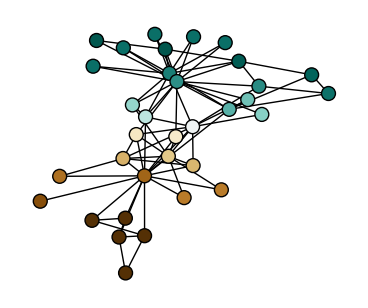

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (4.5, 3.75))
nx.draw(G, pos, ax = ax, node_color = fiedler, cmap = plt.cm.BrBG, node_size = 100, edgecolors = 'black', vmin = -0.2, vmax = 0.2)

We can think of the Fiedler eigenvector as returning a "soft" clustering that gives each node a score rather than a fixed label. We can obtain labels by thresholding according to sign:

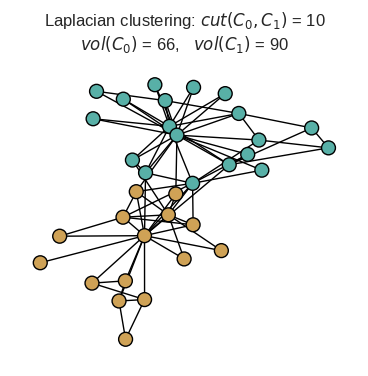

In [14]:
z_fiedler = 1*(fiedler > 0)

fig, ax = plt.subplots(1, 1, figsize = (4.5, 4))
nx.draw(G, pos, ax = ax, node_color = z_fiedler, cmap = plt.cm.BrBG, node_size = 100, edgecolors = 'black', vmin = -0.5, vmax = 1.5)

t = ax.set_title(fr'Laplacian clustering: $cut(C_0, C_1)$ = {cut(A, z_fiedler):.0f}' + "\n" +   fr'$vol(C_0)$ = {vol(A, z_fiedler, 0):.0f},   $vol(C_1)$ = {vol(A, z_fiedler, 1):.0f}')

This clustering looks pretty reasonable! Since we are only *approximately* solving the NormCut problem, it is not strictly guaranteed that this clustering is the best possible one in any sense.

## Multiway Spectral Clustering

It is also possible to use spectral clustering to split a graph into more than two pieces. The general idea is that, when $k$ clusters are desired, we should compute the eigenvectors corresponding to the $k$ smallest eigenvalues of the matrix $\hat{\mL}$ and collect them in a matrix

$$
\begin{aligned}
    \mY = \begin{bmatrix} \vy_1 & \vy_2 & \cdots & \vy_k \end{bmatrix}\;.
\end{aligned}
$$

The row $\vy_i = [v_{i1}, v_{i2}, \ldots, v_{ik}]$ of $\mY$ can be thought of as a set of spatial (Euclidean) coordinates for node $i$. We can then use a Euclidean clustering algorithm like $k$-means in the space of these coordinates in order to obtain a final clustering.

In [15]:
from sklearn.cluster import KMeans

def multiway_spectral(G, k):

    # same as before
    A = nx.to_numpy_array(G)
    D = np.diag(np.sum(A, axis = 1))
    L = D - A
    L_hat = np.linalg.inv(D) @ L
    eigvals, eigvecs = np.linalg.eig(L_hat)

    # Now we get the eigenvectors from the second to the k-th smallest
    idx = np.argsort(eigvals)
    Y = eigvecs[:, idx[0:k]]

    # cluster in the Euclidean space
    KM = KMeans(n_clusters = k)
    KM.fit(Y)
    return KM.labels_

Let's try this on the Les Mis graph!

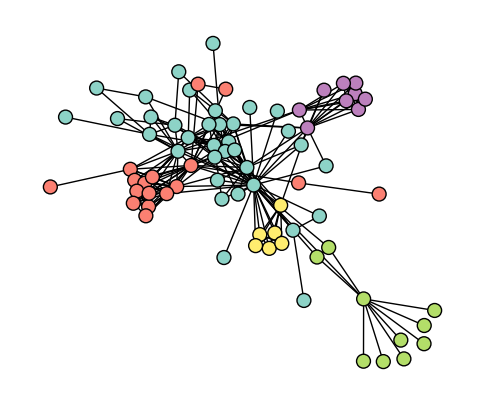

In [16]:
G = unweight(nx.les_miserables_graph())

labels = multiway_spectral(G, 5)

fig, ax = plt.subplots(1, 1, figsize = (6, 5))

nx.draw(G, ax = ax, cmap = plt.cm.Set3, node_color = labels, node_size = 100, edgecolors = 'black')

Visually, the results look fairly reasonable. Multiway spectral clustering can also be justified in terms of approximate normalized cut minimization; see @luxburgTutorialSpectralClustering2007 for details.









## References
